# Определение возраста покупателей

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


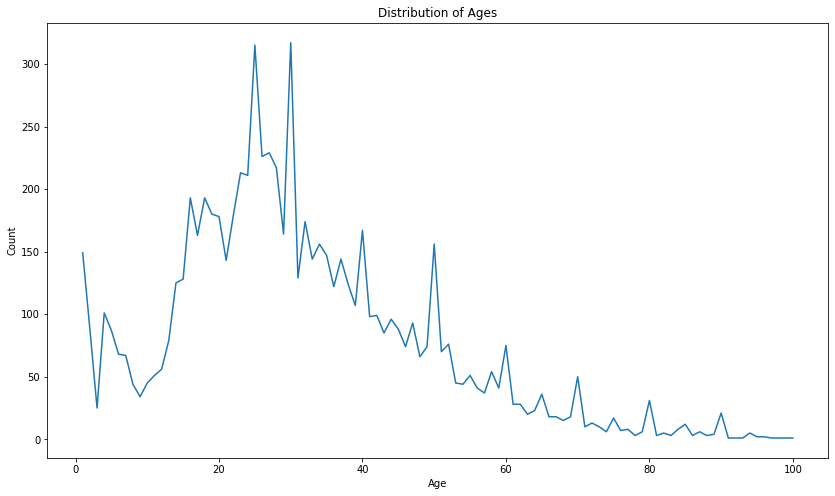

In [ ]:
age_counts = labels['real_age'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
plt.plot(age_counts.index, age_counts.values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')
plt.show()

In [ ]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

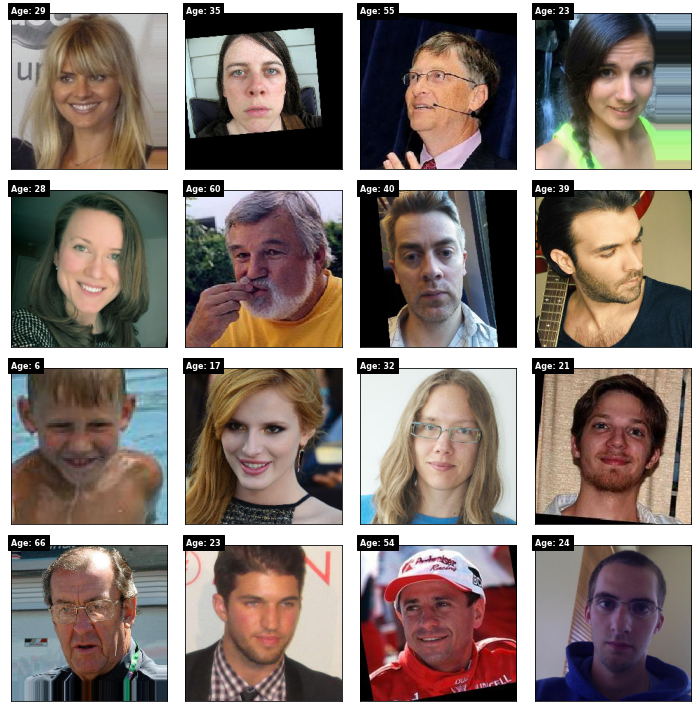

In [ ]:
features, target = next(datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.text(0, 0, f"Age: {target[i]}", color='white', backgroundcolor='black', fontsize=8, weight='bold')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**

* В датасете представлены фотографии людей от 1 до 100 лет
* Размер датасета — 7591 фото
* Больше всего людей между 20 и до 40 годами
* Преимущественно фото сделаны в анфас, некоторые в профиль. При обучении модели стоит сделать аугментацию.

## Обучение модели

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import os
import pandas as pd

def load_train(path):
    
    
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255,
                                    horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    
    test_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)

    return test_datagen_flow



def create_model(input_shape):
    
    optimizer=Adam(learning_rate=0.0001)
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=13,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/13
2023-06-29 08:20:49.186684: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-29 08:20:49.573265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 49s - loss: 236.5616 - mae: 10.9946 - val_loss: 949.7902 - val_mae: 26.0456
Epoch 2/13
178/178 - 40s - loss: 76.9210 - mae: 6.6275 - val_loss: 520.1267 - val_mae: 17.5061
Epoch 3/13
178/178 - 40s - loss: 49.4550 - mae: 5.3430 - val_loss: 250.5904 - val_mae: 11.7087
Epoch 4/13
178/178 - 40s - loss: 35.4242 - mae: 4.5350 - val_loss: 118.4441 - val_mae: 8.3527
Epoch 5/13
178/178 - 38s - loss: 26.8692 - mae: 3.9461 - val_loss: 75.0626 - val_mae: 6.5146
Epoch 6/13
178/178 - 40s - loss: 22.4364 - mae: 3.6027 - val_loss: 66.6440 - val_mae: 6.2121
Epoch 7/13
178/178 - 40s - loss: 19.2785 - mae: 3.3797 - val_loss: 68.1556 - val_mae: 6.2732
Epoch 8/13
178/178 - 40s - loss: 15.8030 - mae: 3.0530 - val_loss: 67.3677 - val_mae: 6.0530
Epoch 9/13
178/178 - 41s - loss: 14.3603 - mae: 2.8747 - val_loss: 78.5520 - val_mae: 6.5387
Epoch 10/13
178/178 - 39s - loss: 11.9748 - mae: 2.5825 - val_loss: 66.5138 - val_mae: 6.1866
Epoch 11/13
178/178 - 38s - loss: 9.6997 - mae: 2.3601 - val_loss: 72.4205 - val_mae: 6.3145
Epoch 12/13
178/178 - 39s - loss: 8.9545 - mae: 2.2674 - val_loss: 60.1947 - val_mae: 5.7448
Epoch 13/13
178/178 - 38s - loss: 7.6640 - mae: 2.1055 - val_loss: 61.7566 - val_mae: 5.8879
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 61.7566 - mae: 5.8879
Test MAE: 5.8879
```

## Анализ обученной модели

* При обучении модели использовался оптимизатор Adam с коэффициентом обучения 0.0001. Так же я использовал более высокие коэффициенты, они показали результаты хуже.

* Использовал несколько видов аугментации.

* На начальных эпохах потеря и средняя абсолютная ошибка значительно снижаются, что указывает на улучшение модели с каждой эпохой.

* Однако на 10-й эпохе наблюдается некоторое увеличение потери на валидационном наборе данных, что может свидетельствовать о переобучении модели. Минимальное значение было достигнуто на 12 эпохе.

* Модель достигла потери и средней абсолютной ошибки на валидационных данных в районе 61.7566  и 5.8879 за 13 эпох.

* Задача — MAE не больше 8, была достигнута. Значение на валидационном наборе данных составляет 5.8879, что означает, что модель в среднем ошибается на 5.9 единиц при прогнозировании реального возраста.